In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from zipfile import ZipFile
import shutil
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [30]:
with ZipFile('./ADL_Dataset.zip', 'r') as zipObj:
    zipObj.extractall()

In [31]:
col_labels = ['X','Y','Z']
raw_txt_files = []
activity_labels = ['Liedown_bed', 'Walk', 'Eat_soup', 'Getup_bed', 'Descend_stairs',
                   'Use_telephone', 'Standup_chair', 'Brush_teeth', 'Climb_stairs',
                   'Sitdown_chair', 'Eat_meat', 'Comb_hair', 'Drink_glass', 'Pour_water']

for activity in activity_labels:
    activity_txts = []
    for file in os.listdir('./HMP_Dataset/'+activity):
        txtdf = pd.read_csv('./HMP_Dataset/'+activity+'/'+file, names=col_labels,  sep=" ")
        activity_txts.append(txtdf)
    raw_txt_files.append(activity_txts)

In [32]:
shutil.rmtree('./HMP_Dataset')
print('Number of samples for each activity:')
for activity, activity_txts in zip(activity_labels, raw_txt_files):
    print(f'    {activity}: {len(activity_txts)}')
print(f'Total number of samples: {sum(len(activity_txts) for activity_txts in raw_txt_files)}')

Number of samples for each activity:
    Liedown_bed: 28
    Walk: 100
    Eat_soup: 3
    Getup_bed: 101
    Descend_stairs: 42
    Use_telephone: 13
    Standup_chair: 102
    Brush_teeth: 12
    Climb_stairs: 102
    Sitdown_chair: 100
    Eat_meat: 5
    Comb_hair: 31
    Drink_glass: 100
    Pour_water: 100
Total number of samples: 839


In [22]:
test_portion = 0.2
perform_computation = True

In [33]:
np_random = np.random.RandomState(12345)
train_val_txt_files = []
test_txt_files = []
for _,activity_txt_files in enumerate(raw_txt_files):
    num_txt_files = len(activity_txt_files)
    shuffled_indices = np.arange(num_txt_files)
    np_random.shuffle(shuffled_indices)

    train_val_txt_files.append([])
    test_txt_files.append([])
    for i, idx in enumerate(shuffled_indices):
        if i < test_portion * num_txt_files:
            test_txt_files[-1].append(activity_txt_files[idx])
        else:
            train_val_txt_files[-1].append(activity_txt_files[idx])

In [7]:
d = 32
k = 100
train_txt_files = train_val_txt_files

In [8]:
def quantize(X, d=32):
    """
    Performs vector quantization.

        Parameters:
                X (np,array): Dimension N x 3
                d (int): The number of samples in the target output

        Returns:
                out (np.array): A numpy array with the a shape: num columns = 3*d.
                This array contains the quantized values of the original X matrix.
    """
    assert X.ndim == 2
    assert X.shape[1] == 3

    # your code here
    cols = X.shape[1] * d
    rows = int(X.size / cols)
    out = np.resize(X, (rows, cols))

    assert out.shape[1] == 3*d
    return out

some_data = (np.arange(135*3, dtype='int64').reshape(-1,3) ** 13) % 20
some_q_data = quantize(some_data, d=32)

assert np.array_equal(some_q_data, np.array([[ 0,  1, 12,  3,  4,  5, 16,  7,  8,  9,  0, 11, 12, 13,  4, 15,
                                               16, 17,  8, 19,  0,  1, 12,  3,  4,  5, 16,  7,  8, 13,  4, 15,
                                               0,  5,  0, 19, 12,  9,  4,  3,  4,  1,  8, 15,  8, 17, 12, 11,
                                               4,  5,  8, 15,  0, 17,  4, 15,  8, 17, 16,  3,  0,  9,  8,  7,
                                               0, 17,  8,  7,  0,  1, 16, 11,  8, 17,  8,  7,  8,  1, 16, 19,
                                               12,  5,  4,  3, 12,  5,  8,  7, 16,  9, 12, 11,  8, 13,  8,  7],
                                             [ 0,  5,  4,  3,  4,  5, 16, 11, 12,  1,  4, 11,  8,  9,  0,  7,
                                               8, 17, 12, 11, 16,  5,  8,  7, 12, 17,  0, 11,  8, 17,  0,  7,
                                               0,  5, 16, 19, 16,  1,  8, 11,  8, 13, 16, 11,  4, 13, 16, 11,
                                               12, 13,  4, 15, 12, 13,  4, 15, 16,  9,  0,  3, 16, 17,  0,  3,
                                               0,  5, 16, 15,  8,  1,  8, 19, 12,  5,  0,  7,  8, 13, 12, 19,
                                               16,  9, 12, 15,  8,  1, 16, 19,  0, 13,  0, 19, 12, 17,  0,  3],
                                             [ 0,  5, 16, 19, 16,  9,  0,  3,  0, 17,  8, 15, 16, 17, 12, 19,
                                               8, 17,  8, 19, 16, 13,  0,  7, 12,  5, 12, 11, 16,  9,  4, 19,
                                               0,  9,  0, 15, 12,  9,  8, 11,  8,  9,  8, 15, 16,  9,  4, 11,
                                               4, 13,  8, 15, 12, 13,  4, 11,  0,  1,  4, 15,  0, 17,  8, 15,
                                               0,  5,  0, 15, 12, 13, 16,  3,  8,  1,  4, 15,  0,  5,  0, 11,
                                               12,  9,  8, 19,  8, 17, 12, 15, 12, 17,  0,  7,  4, 17,  0, 15],
                                             [ 0, 17, 12,  7, 12, 17,  8, 15,  8, 13, 16, 11, 12,  1,  0,  7,
                                               4,  9,  4, 19,  8,  5, 12,  3, 12,  1, 16,  3,  8,  9,  8, 11,
                                               0, 17,  4, 19,  8,  5,  8, 15,  4, 17, 16,  7,  8,  5,  0, 15,
                                               16,  9,  4,  3,  0,  1,  8, 15, 12, 13,  4, 19,  4,  1,  0,  3,
                                               0,  1,  0, 11, 16,  9,  8, 15,  0, 13,  4, 15,  8, 17, 12,  3,
                                               8,  1,  8, 11,  0,  9, 12, 15, 16,  9, 12,  7,  0,  9,  8, 19]]))

In [34]:
quantized_data_for_clustering = []
for activity_idx, activity_txt_files in enumerate(train_txt_files):
    for txt_df in activity_txt_files:
        quantized_text = quantize(txt_df.values, d=d)
        quantized_data_for_clustering.append(quantized_text)
quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

In [10]:
def train_kmeans_model(data, k):
    """
    Performs kmeans clustering.

        Parameters:
                data (np,array): A data matrix of dimension N x d
                k (int): The number of clusters to identify in the data

        Returns:
                kmeans_model (class sklearn.cluster.KMeans): Returns an object that have been fit Kmeans.
                use random_state as indicated in the statement of the problem

    """

    # your code here
    kmeans_model = KMeans(n_clusters=k, random_state=12345).fit(data)

    return kmeans_model

kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

assert kmeans_model.n_clusters == k
assert kmeans_model.random_state == 12345

In [11]:
def text2hist(X, kmeans_model, d, k):
    """
    Creates a normalized count vector representation of the data X.

        Parameters:
                X (np,array): A data matrix of dimension N x d
                kmeans_model (object): An object with a KMeans algorithm pre-trained
                d (int): number of features
                k (int): number of clusters

        Returns:
                hist (ndarray of ints): the normalized count vector.
    """
    assert X.ndim == 2
    assert X.shape[1] == 3
    assert kmeans_model.cluster_centers_.shape == (k, 3*d)

    # your code here
    quantized_data = quantize(X, d)
    km_pred = kmeans_model.predict(quantized_data)
    hist, _ = np.histogram(km_pred, bins=np.arange(k+1), density=True)

    assert hist.ndim == 1
    assert hist.size == k
    assert np.sum(hist).round(2) == 1.
    return hist

some_data = (np.arange(135*3, dtype='int64').reshape(-1,3) ** 13) % 20
some_hist = text2hist(some_data, kmeans_model, d, k)
assert some_hist[some_hist>0].size == 1

In [13]:
def feature_maker(txt_files, kmeans_model, d, k):
    features = []
    labels = []
    for activity_idx, activity_txt_files in enumerate(txt_files):
        for txt_df in activity_txt_files:
            feature_vec = text2hist(txt_df.values, kmeans_model, d=d, k=k)
            features.append(feature_vec.reshape(1,-1))
            labels.append(activity_idx)
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

In [14]:
train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

In [15]:
def train_classifier(train_features, train_labels):
    """
    Creates a random forest classifier.

        Parameters:
                train_features (ndarray): A matrix of dimension n_samples, n_features
                train_labels (ndarray): An matrix of dimension n_samples

        Returns:
                classifier: a trained SKLearn RandomForestClassifier.
    """

    # your code here
    classifier = RandomForestClassifier(n_estimators=100, random_state=12345)
    classifier.fit(train_features, train_labels)

    return classifier

classifier = train_classifier(train_features, train_labels)
assert classifier.n_estimators == 100
assert classifier.random_state == 12345

In [17]:
train_pred = classifier.predict(train_features)
print(f' Training accuracy: {np.mean(train_pred==train_labels)}')
test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
test_pred = classifier.predict(test_features)
print(f' Testing accuracy: {np.mean(test_pred==test_labels)}')

 Training accuracy: 1.0
 Testing accuracy: 0.7398843930635838


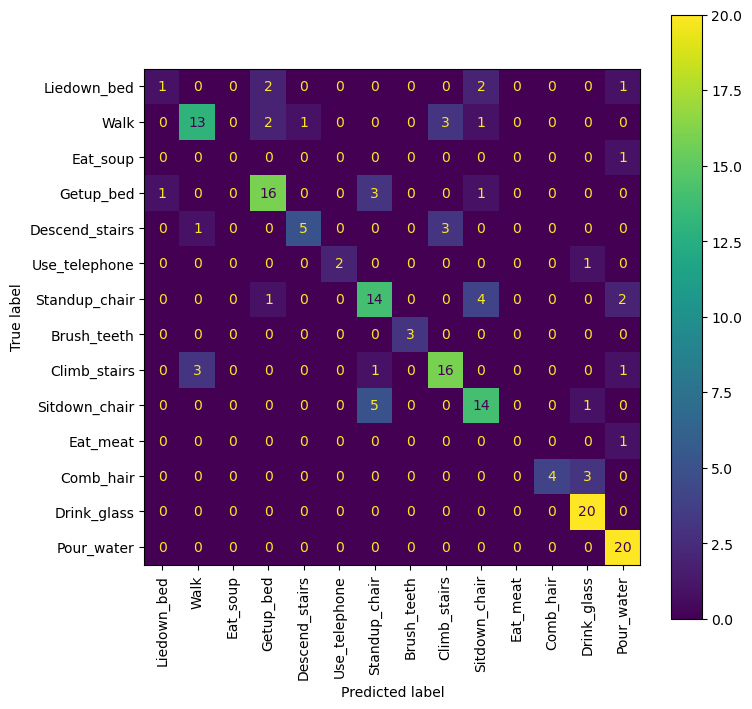

In [18]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
plot_confusion_matrix(classifier, test_features, test_labels,
                      display_labels=activity_labels,
                      xticks_rotation = 'vertical', ax=ax)

In [19]:
def train_and_evaluate(train_txt_files, test_txt_files, d, k, plot_confusion_mat=False):
    quantized_data_for_clustering = []
    for activity_idx, activity_txt_files in enumerate(train_txt_files):
        for txt_df in activity_txt_files:
            quantized_text = quantize(txt_df.values, d=d)
            quantized_data_for_clustering.append(quantized_text)
    quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

    kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

    train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

    classifier = train_classifier(train_features, train_labels)

    test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
    test_pred = classifier.predict(test_features)
    test_acc = np.mean(test_pred==test_labels)

    if plot_confusion_mat:
        fig, ax = plt.subplots(figsize=(8,8), dpi=100)
        plot_confusion_matrix(classifier, test_features, test_labels,
                              display_labels=activity_labels,
                              xticks_rotation = 'vertical', ax=ax)
    return test_acc

In [20]:
def generate_cv_pairs(train_val_txt_files, cv_folds=3):
    cross_val_pairs = []
    for fold_idx in range(cv_folds):
        train_cv_files = []
        val_cv_files = []
        for activity_idx, activity_txt_files in enumerate(train_val_txt_files):
            train_cv_files.append([])
            val_cv_files.append([])
            for i, txt_df in enumerate(activity_txt_files):
                if float(fold_idx+1)/cv_folds > float(i)/len(activity_txt_files) >= float(fold_idx)/cv_folds:
                    val_cv_files[-1].append(txt_df)
                else:
                    train_cv_files[-1].append(txt_df)
        cross_val_pairs.append((train_cv_files,val_cv_files))
    return cross_val_pairs

def perform_cross_validation(cross_val_pairs, k_list, d_list):
    kd_acc = dict()
    for k_candidate in k_list:
        for d_candidate in d_list:
            fold_accs = []
            for train_txt_files, val_txt_files in cross_val_pairs:
                print('.', end='')
                fold_acc = train_and_evaluate(train_txt_files, val_txt_files, d_candidate, k_candidate)
                fold_accs.append(fold_acc)
            cv_acc = np.mean(fold_accs)

            kd_acc[(k_candidate, d_candidate)] = cv_acc
        print('')
    return kd_acc

In [21]:
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]

In [23]:
if perform_computation:
    train_val_txt_files_tiny = [x[:5] for x in train_val_txt_files]
    test_txt_files_tiny = [x[:5] for x in test_txt_files]
    cross_val_pairs_tiny = generate_cv_pairs(train_val_txt_files_tiny, cv_folds=3)
    kd_acc = perform_cross_validation(cross_val_pairs_tiny, k_list=k_list, d_list=d_list)

............
............
............


c:\users\alejanpi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'base'. In the future this will raise TypeError
  


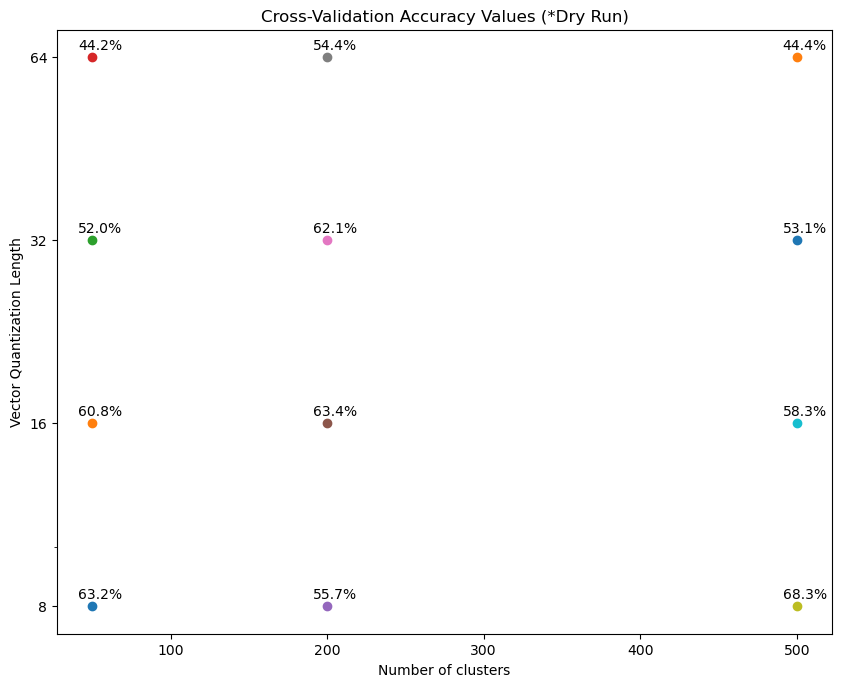

In [24]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    for (k_,d_), acc_ in kd_acc.items():
        ax.scatter([k_], [d_])
        ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Vector Quantization Length')
    ax.set_yscale('symlog', base=2)
    ax.set_yticks(d_list)
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    _ = ax.set_title('Cross-Validation Accuracy Values (*Dry Run)')

Best Number of Clusters (*Dry Run): k=500
Best Quantization Length (*Dry Run): d=8
Tuned Test Accuracy (*Dry Run): 0.6379310344827587


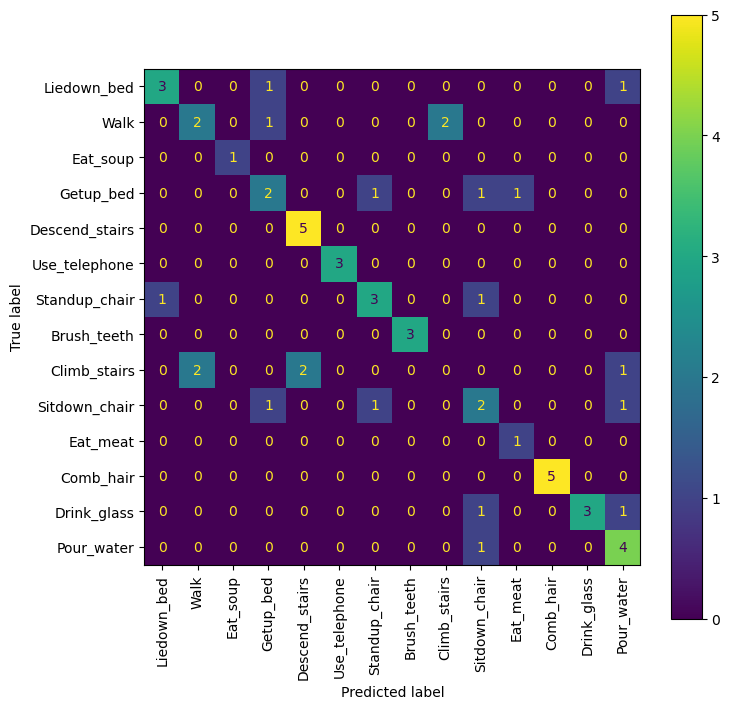

In [25]:
if perform_computation:
    (best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
    test_acc = train_and_evaluate(train_val_txt_files_tiny, test_txt_files_tiny, best_d, best_k, plot_confusion_mat=True)
    print(f'Best Number of Clusters (*Dry Run): k={best_k}')
    print(f'Best Quantization Length (*Dry Run): d={best_d}')
    print(f'Tuned Test Accuracy (*Dry Run): {test_acc}')

In [26]:
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]


In [27]:
if perform_computation:
    cross_val_pairs = generate_cv_pairs(train_val_txt_files, cv_folds=3)
    kd_acc = perform_cross_validation(cross_val_pairs, k_list=k_list, d_list=d_list)

............
............
............


c:\users\alejanpi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'base'. In the future this will raise TypeError
  


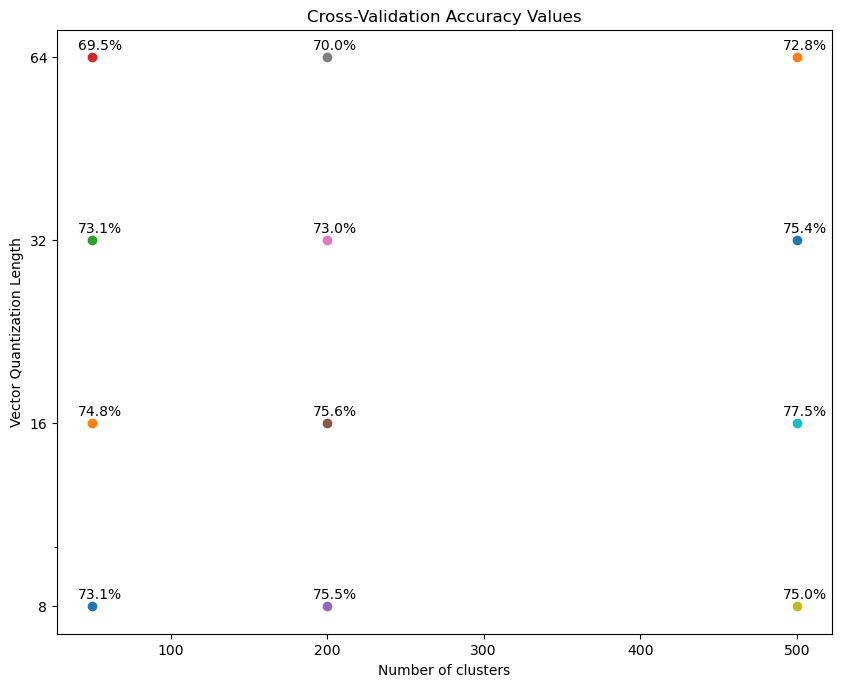

In [28]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    for (k_,d_), acc_ in kd_acc.items():
        ax.scatter([k_], [d_])
        ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Vector Quantization Length')
    ax.set_yscale('symlog', base=2)
    ax.set_yticks(d_list)
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    _ = ax.set_title('Cross-Validation Accuracy Values')

Best Number of Clusters: k=500
Best Quantization Length: d=16
Tuned Test Accuracy: 0.7398843930635838


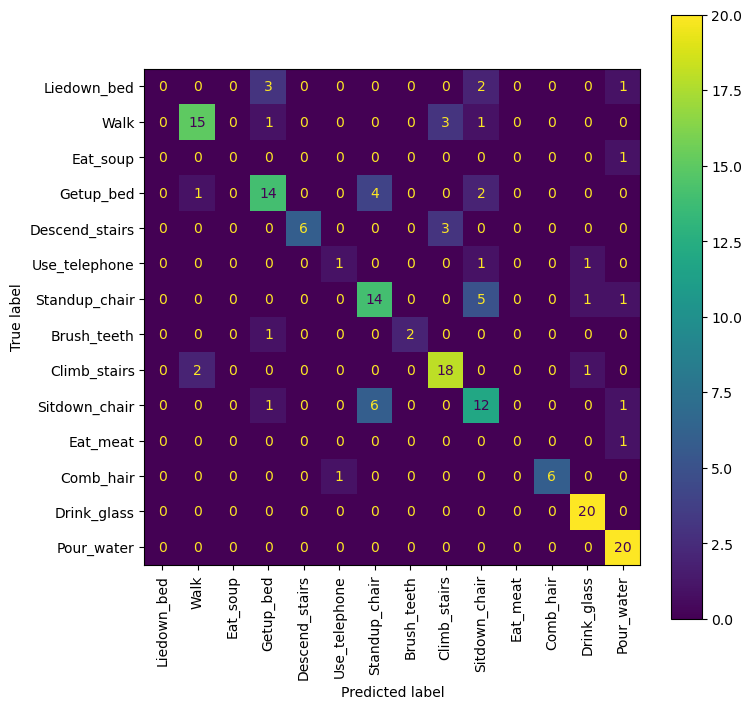

In [29]:
if perform_computation:
    (best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
    test_acc = train_and_evaluate(train_val_txt_files, test_txt_files, best_d, best_k, plot_confusion_mat=True)
    print(f'Best Number of Clusters: k={best_k}')
    print(f'Best Quantization Length: d={best_d}')
    print(f'Tuned Test Accuracy: {test_acc}')